# **Environmental SetUp 🎡**

This section serves as the starting point for the Pedestrian Detection notebook, in this section we imported all the required libraries and modules.

In [ ]:
# Required Library
!pip install -q pycocotools

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# System and OS-related imports
import sys
import os

# NumPy for numerical operations
import numpy as np

# PIL for image processing
from PIL import Image, ImageDraw

# PyTorch and TorchVision
import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Custom modules
import transforms as T
from engine import train_one_epoch, evaluate
import utils

# **Data Loading 🗃️**

The first thing we need to accomplish is to load the data into memory, although the dataset is huge in size and thus loading the whole dataset wont be efficient. That's why we create a Data Loader.

In [ ]:

class PennFudanDataset(object):
    """
    Custom dataset class for PennFudan Pedestrian Detection dataset.

    Args:
    - root (str): Root directory path where the dataset is located.
    - transforms (callable, optional): A function/transform that takes in an image and target,
      and returns a transformed version.

    Attributes:
    - root (str): Root directory path where the dataset is located.
    - transforms (callable, optional): A function/transform that takes in an image and target,
      and returns a transformed version.
    - penn_path (str): Path to the PennFudan dataset.
    - imgs (list): List of image filenames in the dataset.
    - masks (list): List of mask filenames corresponding to the images.

    Methods:
    - __getitem__(self, idx): Retrieves the image and target (annotations) for the given index.
    - __len__(self): Returns the total number of images in the dataset.

    """
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.penn_path = '../input/penn-fudan/'
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        """
        Retrieves the image and target (annotations) for the given index.

        Args:
        - idx (int): Index of the image in the dataset.

        Returns:
        - tuple: A tuple containing the image and target.

        """
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
        - int: Total number of images in the dataset.

        """
        return len(self.imgs)

# **RCNN Classifier 🔍**

This code snippet loads a pre-trained Faster R-CNN model with a ResNet-50 backbone from torchvision and then modifies it for a specific object detection task with a different number of classes. It replaces the box predictor layer with a new one designed for the specified number of classes.

In [ ]:
# Load a pre-trained Faster R-CNN model with a ResNet-50 backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Specify the number of classes in your specific task
num_classes = 2

# Extract the input features for the box predictor layer
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the box predictor with a new one, customized for the specified number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# **RCNN Anchor Detector ⚓**

This code snippet configures a Faster R-CNN model with a MobileNetV2 backbone, sets the output channels of the backbone to 1280, and defines an anchor generator and RoI pooler for the region proposal network (RPN) and region of interest (RoI) operations, respectively.

In [ ]:
# Load a pre-trained MobileNetV2 model as the backbone
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# Set the output channels of the backbone to 1280
backbone.out_channels = 1280

# Define an anchor generator with specific sizes and aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# Define a Region of Interest (RoI) pooler for multi-scale RoI alignment
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# Create a Faster R-CNN model with the specified backbone, number of classes,
# anchor generator, and RoI pooler
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


# **Fast R-CNN Model 🤖**

This function returns an instance segmentation model based on Mask R-CNN with a ResNet50 backbone. It updates the box predictor and mask predictor to match the specified number of classes.

In [ ]:
def get_model_instance_segmentation(num_classes):
    """
    Returns an instance segmentation model based on Mask R-CNN with a ResNet50 backbone.

    Args:
        num_classes (int): Number of object classes in the dataset.

    Returns:
        torchvision.models.detection.MaskRCNN: Instance segmentation model.
    """
    # Load a pre-trained Mask R-CNN model with a ResNet50 backbone
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # Update the box predictor with a new Fast R-CNN predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Update the mask predictor with a new Mask R-CNN predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

Let's make sure to apply some transformation on the imput data to make the model robust.

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# **Fast RCNN Training 👨‍🏭**

This script initializes the necessary components for training an instance segmentation model using Mask R-CNN on the Penn-Fudan dataset. It includes data loading, model instantiation, device configuration, optimizer setup, and the training loop for a specified number of epochs.

In [ ]:
# Define the device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of object classes in the dataset
num_classes = 2

# Dataset root directory
root = '../input/penn-fudan/'

# Create training and testing datasets
dataset = PennFudanDataset(root, get_transform(train=True))
dataset_test = PennFudanDataset(root, get_transform(train=False))

# Split the dataset into training and testing subsets
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Create data loaders for training and testing
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Instantiate the Mask R-CNN model with a ResNet50 backbone
model = get_model_instance_segmentation(num_classes)

# Move the model to the selected device
model.to(device)

# Define the optimizer, learning rate scheduler, and training parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Number of training epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=59)
    lr_scheduler.step()


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [ 0/60]  eta: 0:01:33  lr: 0.000090  loss: 5.2209 (5.2209)  loss_classifier: 0.7243 (0.7243)  loss_box_reg: 0.1437 (0.1437)  loss_mask: 4.2822 (4.2822)  loss_objectness: 0.0643 (0.0643)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 1.5503  data: 0.3088  max mem: 2159
Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.2871 (0.8035)  loss_classifier: 0.0399 (0.1545)  loss_box_reg: 0.0642 (0.1331)  loss_mask: 0.1576 (0.4898)  loss_objectness: 0.0014 (0.0131)  loss_rpn_box_reg: 0.0089 (0.0130)  time: 0.3597  data: 0.0077  max mem: 3135
Epoch: [0] Total time: 0:00:22 (0.3791 s / it)
Epoch: [1]  [ 0/60]  eta: 0:00:40  lr: 0.005000  loss: 0.3966 (0.3966)  loss_classifier: 0.0823 (0.0823)  loss_box_reg: 0.1016 (0.1016)  loss_mask: 0.1932 (0.1932)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0186 (0.0186)  time: 0.6680  data: 0.2838  max mem: 3135
Epoch: [1]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.2207 (0.2382)  loss_classifier: 0.0308 (0.0383)  loss_box_reg: 0.022

In [ ]:
# evaluate on the test dataset
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:13  model_time: 0.0965 (0.0965)  evaluator_time: 0.0101 (0.0101)  time: 0.2706  data: 0.1617  max mem: 3322
Test:  [49/50]  eta: 0:00:00  model_time: 0.0669 (0.0721)  evaluator_time: 0.0036 (0.0052)  time: 0.0817  data: 0.0045  max mem: 3322
Test: Total time: 0:00:04 (0.0867 s / it)
Averaged stats: model_time: 0.0669 (0.0721)  evaluator_time: 0.0036 (0.0052)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.996
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

# **Model Prediction 🔮**

After seeing the fabulous model performance numbers, it's time to visually understand the model's performance and see if it is good.

In [ ]:
dataset = PennFudanDataset(root, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

images, _ = next(iter(data_loader))
images = list(image.cuda() for image in images)

In [ ]:
with torch.no_grad():
    predicted = model(images)

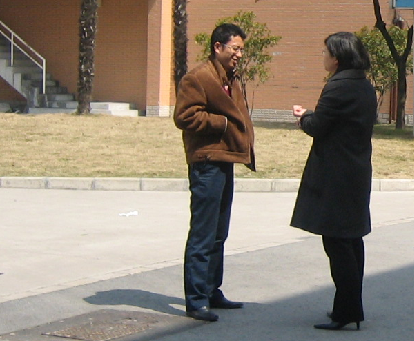

In [ ]:
to_img = ToPILImage()
to_img(images[3].cpu())

In [ ]:
# draw the boxes on the image
im = to_img(images[3].cpu())
mask = Image.new('L', im.size, color=255)
draw=ImageDraw.Draw(mask)
for box in predicted[3]['boxes']:
    draw.rectangle(box.cpu().numpy(), fill=250, outline="red", width=2)
im.putalpha(mask)

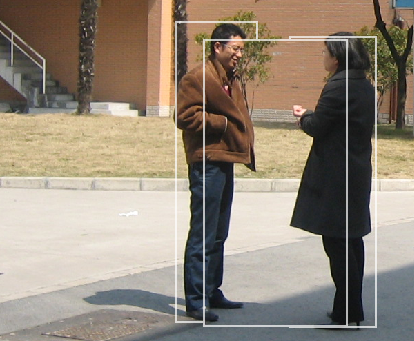

In [ ]:
im

In [ ]:
# Save the entire model (including weights, architecture, optimizer state, etc.)
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
}, 'Pedestrian.pth')
